### Compare the performance of CNN, CNN with batch norm versus fully connected Neural net 

In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
#defining common parameters
batch_size = 32
n_epochs = 20
print_every = 300


In [3]:
#setting up transforming of the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#loading train and val sets
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Extracting C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw


Extracting C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw



Extracting C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw


Extracting C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Cyril Bosse-Platiere/.pytorch/FMNIST_data/FashionMNIST\raw
Processing...
Done!


{'Sneaker': 7, 'Dress': 3, 'Trouser': 1, 'T-shirt/top': 0, 'Pullover': 2, 'Bag': 8, 'Coat': 4, 'Shirt': 6, 'Ankle boot': 9, 'Sandal': 5}


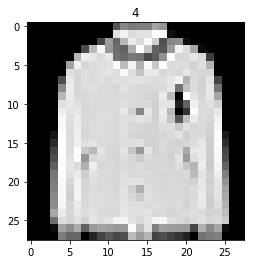

In [4]:
img, lab = next(iter(trainloader))
fig, ax = plt.subplots()
ax.imshow(np.squeeze(img[0].numpy()), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
ax.set_title(str(lab[0].item()))
print(trainset.class_to_idx)

In [5]:
#create a fully connected layer
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super(MLP, self).__init__()
        
        #first layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        #intermediate layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for (h1, h2) in layer_sizes])
        
        #output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        #droput
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        #looping through hidden layers
        x = x.view(x.shape[0], -1)
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        
        #final layer
        x = self.output(x)
        
        #softmax for multi output classifications
        x = F.log_softmax(x, dim=1)
        
        return x
        
        

In [6]:
#image size after Convolution = (size_before - kernel_size + 2*padding) // stride + 1 
def conv(in_channels, out_channels, kernel_size, stride, padding=1, batch_norm=True, maxpool=True):
    layers=[]
    
    conv_layers = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                           stride=stride, padding=padding, bias = (not batch_norm))
    layers.append(conv_layers)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    #if maxpool: #onlyu sue maxpool for large images, to adapt this size stride / use
    #    layers.append(nn.MaxPool2d(2,2))
    
    return nn.Sequential(*layers)

In [7]:
#create a CNN/maxpooling where depths increase by 2 for each convolution starting from a given conv_dims_base
#we assume a square image
class CNN(nn.Module):
    def __init__(self,  conv_dims_base, conv_depth, image_size, output_size, bact_norm=False, drop_p=0.5):
        super(CNN, self).__init__()
        
        #first convolutio
        self.conv_layers = nn.ModuleList([conv(1, conv_dims_base, kernel_size=3, stride=2, batch_norm=bact_norm)])  
        self.image_size = int(image_size / 2)
        
        if conv_depth>1:
            self.conv_layers.extend([conv(conv_dims_base * 2**(i-1), conv_dims_base * 2**i,
                                          kernel_size=3, stride=2, batch_norm=bact_norm) for i in np.arange(1, conv_depth)])
            self.image_size = int(self.image_size /  2 **(conv_depth-1))
        
        self.fc1 = nn.Linear(self.image_size*self.image_size * conv_dims_base * 2**(conv_depth-1), 2*output_size)
        self.fc2 = nn.Linear(2*output_size, output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):

        for each in self.conv_layers:
            x = F.relu(each(x))
    
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x


In [8]:
def complexity_parameters(neural_net):
    #Computing the numbers of parameters involved for a given neural net
    param_count=0
    
    for i in neural_net.state_dict().values():
        dim_i = list(i.shape)
        param_count += np.prod(dim_i)
    
    return int(param_count)

In [9]:
mlp = MLP(28*28, 10, [64,128])
print(complexity_parameters(mlp))

cnn = CNN(16, 2, 28, 10)
print(complexity_parameters(cnn))

cnn_batch = CNN(16, 2, 28, 10, bact_norm=True)
print(complexity_parameters(cnn_batch))

59850
36390
36536


### Due to its easier calibration, we allow the mlp to have much more parameters than the CNN
Let's train them now

In [10]:
criterion = nn.NLLLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)
optimizer_cnn_batch = optim.Adam(cnn_batch.parameters(), lr=0.001)

### Let's do the training

In [11]:
def training(model, optimizer, criterion, trainloader, testloader, n_epochs, save_path, need_eval=False, print_every=100):
    if need_eval:
        model.train()
        
    test_loss_min = np.Inf 
    list_train_loss, list_test_loss, list_accuracy = [], [], []
    
    for e in tqdm(range(n_epochs)):
        
        train_loss = 0
        test_loss = 0
        accuracy = 0
        n_batch = len(trainloader)
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += 1/(batch_idx+1) * (loss.item() - train_loss)
            
            if (batch_idx + 1) %print_every == 0 or batch_idx == n_batch-1:
                print("Current Epoch: {}/{}, Current Progress: {}/{}, Train Loss: {:.6f}".format(e+1, n_epochs, batch_idx+1, 
                                                                                               n_batch, train_loss))
        ######################    
        # validate the model #
        ######################
        if need_eval:
            model.eval()
        for inputs, labels in testloader:
            with torch.no_grad():
                outputs = model(inputs)
                
                ps = torch.exp(outputs)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class==labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
        test_loss /= len(testloader)
        accuracy /= len(testloader)
        if need_eval:
            model.train()
        
        print("Current Epoch: {}/{}, Test Loss: {:.6f}, Test Accuracy: {:.3f} %".format(e+1, n_epochs, 
                                                                                        test_loss, 100*accuracy))
        
        if test_loss < test_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(test_loss_min, test_loss))
            torch.save(model.state_dict(), save_path)
            test_loss_min = test_loss
        
        
        
        list_train_loss += [train_loss]
        list_test_loss += [test_loss]
        list_accuracy += [accuracy]

        
    return [list_train_loss, list_test_loss, list_accuracy]

In [12]:
mlp_metrics = training(mlp, optimizer_mlp, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\mlp.pt",need_eval=True, print_every=print_every)
cnn_metrics = training(cnn, optimizer_cnn, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\cnn.pt",need_eval=False, print_every=print_every)
cnn_batch_metrics = training(cnn_batch, optimizer_cnn_batch, criterion, trainloader, testloader, n_epochs=n_epochs, 
                                         save_path="trained_models\cnn_batch.pt",need_eval=True, print_every=print_every)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 1/20, Current Progress: 300/1875, Train Loss: 1.157184
Current Epoch: 1/20, Current Progress: 600/1875, Train Loss: 0.977175
Current Epoch: 1/20, Current Progress: 900/1875, Train Loss: 0.895231
Current Epoch: 1/20, Current Progress: 1200/1875, Train Loss: 0.847079
Current Epoch: 1/20, Current Progress: 1500/1875, Train Loss: 0.809854
Current Epoch: 1/20, Current Progress: 1800/1875, Train Loss: 0.780145
Current Epoch: 1/20, Current Progress: 1875/1875, Train Loss: 0.775614


  5%|████▏                                                                              | 1/20 [00:44<14:05, 44.49s/it]

Current Epoch: 1/20, Test Loss: 0.513035, Test Accuracy: 81.979 %
Validation loss decreased (inf --> 0.513035). Saving model ...
Current Epoch: 2/20, Current Progress: 300/1875, Train Loss: 0.603008
Current Epoch: 2/20, Current Progress: 600/1875, Train Loss: 0.610829
Current Epoch: 2/20, Current Progress: 900/1875, Train Loss: 0.611440
Current Epoch: 2/20, Current Progress: 1200/1875, Train Loss: 0.611076
Current Epoch: 2/20, Current Progress: 1500/1875, Train Loss: 0.606537
Current Epoch: 2/20, Current Progress: 1800/1875, Train Loss: 0.604910
Current Epoch: 2/20, Current Progress: 1875/1875, Train Loss: 0.605907


 10%|████████▎                                                                          | 2/20 [01:27<13:10, 43.94s/it]

Current Epoch: 2/20, Test Loss: 0.483827, Test Accuracy: 82.688 %
Validation loss decreased (0.513035 --> 0.483827). Saving model ...
Current Epoch: 3/20, Current Progress: 300/1875, Train Loss: 0.552140
Current Epoch: 3/20, Current Progress: 600/1875, Train Loss: 0.562298
Current Epoch: 3/20, Current Progress: 900/1875, Train Loss: 0.560077
Current Epoch: 3/20, Current Progress: 1200/1875, Train Loss: 0.567431
Current Epoch: 3/20, Current Progress: 1500/1875, Train Loss: 0.565070
Current Epoch: 3/20, Current Progress: 1800/1875, Train Loss: 0.565063
Current Epoch: 3/20, Current Progress: 1875/1875, Train Loss: 0.565965


 15%|████████████▍                                                                      | 3/20 [02:07<12:09, 42.94s/it]

Current Epoch: 3/20, Test Loss: 0.454251, Test Accuracy: 83.207 %
Validation loss decreased (0.483827 --> 0.454251). Saving model ...
Current Epoch: 4/20, Current Progress: 300/1875, Train Loss: 0.545137
Current Epoch: 4/20, Current Progress: 600/1875, Train Loss: 0.543658
Current Epoch: 4/20, Current Progress: 900/1875, Train Loss: 0.542573
Current Epoch: 4/20, Current Progress: 1200/1875, Train Loss: 0.545020
Current Epoch: 4/20, Current Progress: 1500/1875, Train Loss: 0.546100
Current Epoch: 4/20, Current Progress: 1800/1875, Train Loss: 0.547647
Current Epoch: 4/20, Current Progress: 1875/1875, Train Loss: 0.548969


 20%|████████████████▌                                                                  | 4/20 [02:50<11:24, 42.80s/it]

Current Epoch: 4/20, Test Loss: 0.448402, Test Accuracy: 83.576 %
Validation loss decreased (0.454251 --> 0.448402). Saving model ...
Current Epoch: 5/20, Current Progress: 300/1875, Train Loss: 0.538823
Current Epoch: 5/20, Current Progress: 600/1875, Train Loss: 0.536141
Current Epoch: 5/20, Current Progress: 900/1875, Train Loss: 0.530248
Current Epoch: 5/20, Current Progress: 1200/1875, Train Loss: 0.536853
Current Epoch: 5/20, Current Progress: 1500/1875, Train Loss: 0.534387
Current Epoch: 5/20, Current Progress: 1800/1875, Train Loss: 0.535768
Current Epoch: 5/20, Current Progress: 1875/1875, Train Loss: 0.536023


 25%|████████████████████▊                                                              | 5/20 [03:33<10:44, 42.96s/it]

Current Epoch: 5/20, Test Loss: 0.448087, Test Accuracy: 83.367 %
Validation loss decreased (0.448402 --> 0.448087). Saving model ...
Current Epoch: 6/20, Current Progress: 300/1875, Train Loss: 0.537176
Current Epoch: 6/20, Current Progress: 600/1875, Train Loss: 0.527826
Current Epoch: 6/20, Current Progress: 900/1875, Train Loss: 0.529804
Current Epoch: 6/20, Current Progress: 1200/1875, Train Loss: 0.528047
Current Epoch: 6/20, Current Progress: 1500/1875, Train Loss: 0.526857
Current Epoch: 6/20, Current Progress: 1800/1875, Train Loss: 0.525140
Current Epoch: 6/20, Current Progress: 1875/1875, Train Loss: 0.527170


 30%|████████████████████████▉                                                          | 6/20 [04:05<09:13, 39.53s/it]

Current Epoch: 6/20, Test Loss: 0.437962, Test Accuracy: 83.936 %
Validation loss decreased (0.448087 --> 0.437962). Saving model ...
Current Epoch: 7/20, Current Progress: 300/1875, Train Loss: 0.513245
Current Epoch: 7/20, Current Progress: 600/1875, Train Loss: 0.517853
Current Epoch: 7/20, Current Progress: 900/1875, Train Loss: 0.514196
Current Epoch: 7/20, Current Progress: 1200/1875, Train Loss: 0.513620
Current Epoch: 7/20, Current Progress: 1500/1875, Train Loss: 0.512316
Current Epoch: 7/20, Current Progress: 1800/1875, Train Loss: 0.513830
Current Epoch: 7/20, Current Progress: 1875/1875, Train Loss: 0.512167


 35%|█████████████████████████████                                                      | 7/20 [04:47<08:46, 40.52s/it]

Current Epoch: 7/20, Test Loss: 0.447903, Test Accuracy: 83.666 %
Current Epoch: 8/20, Current Progress: 300/1875, Train Loss: 0.522648
Current Epoch: 8/20, Current Progress: 600/1875, Train Loss: 0.511100
Current Epoch: 8/20, Current Progress: 900/1875, Train Loss: 0.515691
Current Epoch: 8/20, Current Progress: 1200/1875, Train Loss: 0.513004
Current Epoch: 8/20, Current Progress: 1500/1875, Train Loss: 0.513196
Current Epoch: 8/20, Current Progress: 1800/1875, Train Loss: 0.511009
Current Epoch: 8/20, Current Progress: 1875/1875, Train Loss: 0.511024


 40%|█████████████████████████████████▏                                                 | 8/20 [05:30<08:11, 41.00s/it]

Current Epoch: 8/20, Test Loss: 0.425825, Test Accuracy: 84.615 %
Validation loss decreased (0.437962 --> 0.425825). Saving model ...
Current Epoch: 9/20, Current Progress: 300/1875, Train Loss: 0.491220
Current Epoch: 9/20, Current Progress: 600/1875, Train Loss: 0.489739
Current Epoch: 9/20, Current Progress: 900/1875, Train Loss: 0.496040
Current Epoch: 9/20, Current Progress: 1200/1875, Train Loss: 0.502052
Current Epoch: 9/20, Current Progress: 1500/1875, Train Loss: 0.501989
Current Epoch: 9/20, Current Progress: 1800/1875, Train Loss: 0.504018
Current Epoch: 9/20, Current Progress: 1875/1875, Train Loss: 0.502724


 45%|█████████████████████████████████████▎                                             | 9/20 [06:11<07:33, 41.20s/it]

Current Epoch: 9/20, Test Loss: 0.426412, Test Accuracy: 84.465 %
Current Epoch: 10/20, Current Progress: 300/1875, Train Loss: 0.477008
Current Epoch: 10/20, Current Progress: 600/1875, Train Loss: 0.485605
Current Epoch: 10/20, Current Progress: 900/1875, Train Loss: 0.486253
Current Epoch: 10/20, Current Progress: 1200/1875, Train Loss: 0.495533
Current Epoch: 10/20, Current Progress: 1500/1875, Train Loss: 0.494975
Current Epoch: 10/20, Current Progress: 1800/1875, Train Loss: 0.495419
Current Epoch: 10/20, Current Progress: 1875/1875, Train Loss: 0.494303


 50%|█████████████████████████████████████████                                         | 10/20 [06:53<06:54, 41.47s/it]

Current Epoch: 10/20, Test Loss: 0.415750, Test Accuracy: 84.325 %
Validation loss decreased (0.425825 --> 0.415750). Saving model ...
Current Epoch: 11/20, Current Progress: 300/1875, Train Loss: 0.497717
Current Epoch: 11/20, Current Progress: 600/1875, Train Loss: 0.493303
Current Epoch: 11/20, Current Progress: 900/1875, Train Loss: 0.494651
Current Epoch: 11/20, Current Progress: 1200/1875, Train Loss: 0.496857
Current Epoch: 11/20, Current Progress: 1500/1875, Train Loss: 0.499824
Current Epoch: 11/20, Current Progress: 1800/1875, Train Loss: 0.496679
Current Epoch: 11/20, Current Progress: 1875/1875, Train Loss: 0.497293


 55%|█████████████████████████████████████████████                                     | 11/20 [07:37<06:19, 42.21s/it]

Current Epoch: 11/20, Test Loss: 0.431649, Test Accuracy: 84.046 %
Current Epoch: 12/20, Current Progress: 300/1875, Train Loss: 0.504443
Current Epoch: 12/20, Current Progress: 600/1875, Train Loss: 0.496046
Current Epoch: 12/20, Current Progress: 900/1875, Train Loss: 0.491891
Current Epoch: 12/20, Current Progress: 1200/1875, Train Loss: 0.492921
Current Epoch: 12/20, Current Progress: 1500/1875, Train Loss: 0.491309
Current Epoch: 12/20, Current Progress: 1800/1875, Train Loss: 0.488436
Current Epoch: 12/20, Current Progress: 1875/1875, Train Loss: 0.490877


 60%|█████████████████████████████████████████████████▏                                | 12/20 [08:19<05:37, 42.15s/it]

Current Epoch: 12/20, Test Loss: 0.425055, Test Accuracy: 84.495 %
Current Epoch: 13/20, Current Progress: 300/1875, Train Loss: 0.477879
Current Epoch: 13/20, Current Progress: 600/1875, Train Loss: 0.476072
Current Epoch: 13/20, Current Progress: 900/1875, Train Loss: 0.482325
Current Epoch: 13/20, Current Progress: 1200/1875, Train Loss: 0.487494
Current Epoch: 13/20, Current Progress: 1500/1875, Train Loss: 0.490109
Current Epoch: 13/20, Current Progress: 1800/1875, Train Loss: 0.491190
Current Epoch: 13/20, Current Progress: 1875/1875, Train Loss: 0.492041


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [09:03<04:58, 42.67s/it]

Current Epoch: 13/20, Test Loss: 0.416652, Test Accuracy: 84.764 %
Current Epoch: 14/20, Current Progress: 300/1875, Train Loss: 0.490377
Current Epoch: 14/20, Current Progress: 600/1875, Train Loss: 0.490466
Current Epoch: 14/20, Current Progress: 900/1875, Train Loss: 0.494330
Current Epoch: 14/20, Current Progress: 1200/1875, Train Loss: 0.489671
Current Epoch: 14/20, Current Progress: 1500/1875, Train Loss: 0.486172
Current Epoch: 14/20, Current Progress: 1800/1875, Train Loss: 0.483785
Current Epoch: 14/20, Current Progress: 1875/1875, Train Loss: 0.482677


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [09:47<04:18, 43.13s/it]

Current Epoch: 14/20, Test Loss: 0.423122, Test Accuracy: 84.864 %
Current Epoch: 15/20, Current Progress: 300/1875, Train Loss: 0.492102
Current Epoch: 15/20, Current Progress: 600/1875, Train Loss: 0.490959
Current Epoch: 15/20, Current Progress: 900/1875, Train Loss: 0.489731
Current Epoch: 15/20, Current Progress: 1200/1875, Train Loss: 0.488436
Current Epoch: 15/20, Current Progress: 1500/1875, Train Loss: 0.484417
Current Epoch: 15/20, Current Progress: 1800/1875, Train Loss: 0.485917
Current Epoch: 15/20, Current Progress: 1875/1875, Train Loss: 0.487460


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [10:32<03:37, 43.54s/it]

Current Epoch: 15/20, Test Loss: 0.419824, Test Accuracy: 84.974 %
Current Epoch: 16/20, Current Progress: 300/1875, Train Loss: 0.489728
Current Epoch: 16/20, Current Progress: 600/1875, Train Loss: 0.483661
Current Epoch: 16/20, Current Progress: 900/1875, Train Loss: 0.474241
Current Epoch: 16/20, Current Progress: 1200/1875, Train Loss: 0.479283
Current Epoch: 16/20, Current Progress: 1500/1875, Train Loss: 0.479862
Current Epoch: 16/20, Current Progress: 1800/1875, Train Loss: 0.482429
Current Epoch: 16/20, Current Progress: 1875/1875, Train Loss: 0.482197


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [11:16<02:55, 43.77s/it]

Current Epoch: 16/20, Test Loss: 0.409311, Test Accuracy: 85.254 %
Validation loss decreased (0.415750 --> 0.409311). Saving model ...
Current Epoch: 17/20, Current Progress: 300/1875, Train Loss: 0.473899
Current Epoch: 17/20, Current Progress: 600/1875, Train Loss: 0.481284
Current Epoch: 17/20, Current Progress: 900/1875, Train Loss: 0.481458
Current Epoch: 17/20, Current Progress: 1200/1875, Train Loss: 0.478906
Current Epoch: 17/20, Current Progress: 1500/1875, Train Loss: 0.476713
Current Epoch: 17/20, Current Progress: 1800/1875, Train Loss: 0.478989
Current Epoch: 17/20, Current Progress: 1875/1875, Train Loss: 0.478940


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [12:01<02:11, 43.97s/it]

Current Epoch: 17/20, Test Loss: 0.402226, Test Accuracy: 85.653 %
Validation loss decreased (0.409311 --> 0.402226). Saving model ...
Current Epoch: 18/20, Current Progress: 300/1875, Train Loss: 0.452628
Current Epoch: 18/20, Current Progress: 600/1875, Train Loss: 0.470457
Current Epoch: 18/20, Current Progress: 900/1875, Train Loss: 0.472051
Current Epoch: 18/20, Current Progress: 1200/1875, Train Loss: 0.479286
Current Epoch: 18/20, Current Progress: 1500/1875, Train Loss: 0.476368
Current Epoch: 18/20, Current Progress: 1800/1875, Train Loss: 0.474995
Current Epoch: 18/20, Current Progress: 1875/1875, Train Loss: 0.474951


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [12:40<01:24, 42.49s/it]

Current Epoch: 18/20, Test Loss: 0.410445, Test Accuracy: 85.094 %
Current Epoch: 19/20, Current Progress: 300/1875, Train Loss: 0.453824
Current Epoch: 19/20, Current Progress: 600/1875, Train Loss: 0.456928
Current Epoch: 19/20, Current Progress: 900/1875, Train Loss: 0.470072
Current Epoch: 19/20, Current Progress: 1200/1875, Train Loss: 0.475132
Current Epoch: 19/20, Current Progress: 1500/1875, Train Loss: 0.472739
Current Epoch: 19/20, Current Progress: 1800/1875, Train Loss: 0.473244
Current Epoch: 19/20, Current Progress: 1875/1875, Train Loss: 0.473767


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [13:23<00:42, 42.84s/it]

Current Epoch: 19/20, Test Loss: 0.408350, Test Accuracy: 85.274 %
Current Epoch: 20/20, Current Progress: 300/1875, Train Loss: 0.492023
Current Epoch: 20/20, Current Progress: 600/1875, Train Loss: 0.478489
Current Epoch: 20/20, Current Progress: 900/1875, Train Loss: 0.475283
Current Epoch: 20/20, Current Progress: 1200/1875, Train Loss: 0.480168
Current Epoch: 20/20, Current Progress: 1500/1875, Train Loss: 0.477709
Current Epoch: 20/20, Current Progress: 1800/1875, Train Loss: 0.476248
Current Epoch: 20/20, Current Progress: 1875/1875, Train Loss: 0.475674


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 20/20, Test Loss: 0.411095, Test Accuracy: 85.234 %
Current Epoch: 1/20, Current Progress: 300/1875, Train Loss: 1.589546
Current Epoch: 1/20, Current Progress: 600/1875, Train Loss: 1.427875
Current Epoch: 1/20, Current Progress: 900/1875, Train Loss: 1.347459
Current Epoch: 1/20, Current Progress: 1200/1875, Train Loss: 1.304280
Current Epoch: 1/20, Current Progress: 1500/1875, Train Loss: 1.270460
Current Epoch: 1/20, Current Progress: 1800/1875, Train Loss: 1.243058
Current Epoch: 1/20, Current Progress: 1875/1875, Train Loss: 1.236874


  5%|████▏                                                                              | 1/20 [01:31<28:56, 91.42s/it]

Current Epoch: 1/20, Test Loss: 1.116953, Test Accuracy: 56.470 %
Validation loss decreased (inf --> 1.116953). Saving model ...
Current Epoch: 2/20, Current Progress: 300/1875, Train Loss: 1.082440
Current Epoch: 2/20, Current Progress: 600/1875, Train Loss: 1.083312
Current Epoch: 2/20, Current Progress: 900/1875, Train Loss: 1.077457
Current Epoch: 2/20, Current Progress: 1200/1875, Train Loss: 1.071556
Current Epoch: 2/20, Current Progress: 1500/1875, Train Loss: 1.064176
Current Epoch: 2/20, Current Progress: 1800/1875, Train Loss: 1.063218
Current Epoch: 2/20, Current Progress: 1875/1875, Train Loss: 1.062966


 10%|████████▎                                                                          | 2/20 [02:59<27:08, 90.45s/it]

Current Epoch: 2/20, Test Loss: 1.060688, Test Accuracy: 58.466 %
Validation loss decreased (1.116953 --> 1.060688). Saving model ...
Current Epoch: 3/20, Current Progress: 300/1875, Train Loss: 1.029575
Current Epoch: 3/20, Current Progress: 600/1875, Train Loss: 1.019673
Current Epoch: 3/20, Current Progress: 900/1875, Train Loss: 1.017164
Current Epoch: 3/20, Current Progress: 1200/1875, Train Loss: 1.016491
Current Epoch: 3/20, Current Progress: 1500/1875, Train Loss: 1.012752
Current Epoch: 3/20, Current Progress: 1800/1875, Train Loss: 1.009329
Current Epoch: 3/20, Current Progress: 1875/1875, Train Loss: 1.008308


 15%|████████████▍                                                                      | 3/20 [04:30<25:42, 90.73s/it]

Current Epoch: 3/20, Test Loss: 1.004157, Test Accuracy: 59.974 %
Validation loss decreased (1.060688 --> 1.004157). Saving model ...
Current Epoch: 4/20, Current Progress: 300/1875, Train Loss: 0.979111
Current Epoch: 4/20, Current Progress: 600/1875, Train Loss: 0.968766
Current Epoch: 4/20, Current Progress: 900/1875, Train Loss: 0.947230
Current Epoch: 4/20, Current Progress: 1200/1875, Train Loss: 0.931200
Current Epoch: 4/20, Current Progress: 1500/1875, Train Loss: 0.920682
Current Epoch: 4/20, Current Progress: 1800/1875, Train Loss: 0.911383
Current Epoch: 4/20, Current Progress: 1875/1875, Train Loss: 0.908484


 20%|████████████████▌                                                                  | 4/20 [06:05<24:27, 91.73s/it]

Current Epoch: 4/20, Test Loss: 0.874702, Test Accuracy: 66.074 %
Validation loss decreased (1.004157 --> 0.874702). Saving model ...
Current Epoch: 5/20, Current Progress: 300/1875, Train Loss: 0.841757
Current Epoch: 5/20, Current Progress: 600/1875, Train Loss: 0.842848
Current Epoch: 5/20, Current Progress: 900/1875, Train Loss: 0.845943
Current Epoch: 5/20, Current Progress: 1200/1875, Train Loss: 0.849762
Current Epoch: 5/20, Current Progress: 1500/1875, Train Loss: 0.846269
Current Epoch: 5/20, Current Progress: 1800/1875, Train Loss: 0.845216
Current Epoch: 5/20, Current Progress: 1875/1875, Train Loss: 0.843939


 25%|████████████████████▊                                                              | 5/20 [07:36<22:54, 91.60s/it]

Current Epoch: 5/20, Test Loss: 0.863314, Test Accuracy: 66.733 %
Validation loss decreased (0.874702 --> 0.863314). Saving model ...
Current Epoch: 6/20, Current Progress: 300/1875, Train Loss: 0.823531
Current Epoch: 6/20, Current Progress: 600/1875, Train Loss: 0.814980
Current Epoch: 6/20, Current Progress: 900/1875, Train Loss: 0.813000
Current Epoch: 6/20, Current Progress: 1200/1875, Train Loss: 0.806303
Current Epoch: 6/20, Current Progress: 1500/1875, Train Loss: 0.801453
Current Epoch: 6/20, Current Progress: 1800/1875, Train Loss: 0.801086
Current Epoch: 6/20, Current Progress: 1875/1875, Train Loss: 0.798531


 30%|████████████████████████▉                                                          | 6/20 [09:13<21:43, 93.13s/it]

Current Epoch: 6/20, Test Loss: 0.822658, Test Accuracy: 69.519 %
Validation loss decreased (0.863314 --> 0.822658). Saving model ...
Current Epoch: 7/20, Current Progress: 300/1875, Train Loss: 0.768350
Current Epoch: 7/20, Current Progress: 600/1875, Train Loss: 0.766610
Current Epoch: 7/20, Current Progress: 900/1875, Train Loss: 0.767646
Current Epoch: 7/20, Current Progress: 1200/1875, Train Loss: 0.766309
Current Epoch: 7/20, Current Progress: 1500/1875, Train Loss: 0.770051
Current Epoch: 7/20, Current Progress: 1800/1875, Train Loss: 0.766726
Current Epoch: 7/20, Current Progress: 1875/1875, Train Loss: 0.764822


 35%|█████████████████████████████                                                      | 7/20 [10:42<19:55, 91.99s/it]

Current Epoch: 7/20, Test Loss: 0.781320, Test Accuracy: 70.966 %
Validation loss decreased (0.822658 --> 0.781320). Saving model ...
Current Epoch: 8/20, Current Progress: 300/1875, Train Loss: 0.734939
Current Epoch: 8/20, Current Progress: 600/1875, Train Loss: 0.741704
Current Epoch: 8/20, Current Progress: 900/1875, Train Loss: 0.737031
Current Epoch: 8/20, Current Progress: 1200/1875, Train Loss: 0.737567
Current Epoch: 8/20, Current Progress: 1500/1875, Train Loss: 0.739069
Current Epoch: 8/20, Current Progress: 1800/1875, Train Loss: 0.738924
Current Epoch: 8/20, Current Progress: 1875/1875, Train Loss: 0.739230


 40%|█████████████████████████████████▏                                                 | 8/20 [12:23<18:57, 94.82s/it]

Current Epoch: 8/20, Test Loss: 0.760043, Test Accuracy: 72.334 %
Validation loss decreased (0.781320 --> 0.760043). Saving model ...
Current Epoch: 9/20, Current Progress: 300/1875, Train Loss: 0.729083
Current Epoch: 9/20, Current Progress: 600/1875, Train Loss: 0.729965
Current Epoch: 9/20, Current Progress: 900/1875, Train Loss: 0.730633
Current Epoch: 9/20, Current Progress: 1200/1875, Train Loss: 0.732300
Current Epoch: 9/20, Current Progress: 1500/1875, Train Loss: 0.732178
Current Epoch: 9/20, Current Progress: 1800/1875, Train Loss: 0.729669
Current Epoch: 9/20, Current Progress: 1875/1875, Train Loss: 0.729499


 45%|█████████████████████████████████████▎                                             | 9/20 [14:05<17:46, 96.97s/it]

Current Epoch: 9/20, Test Loss: 0.776031, Test Accuracy: 71.995 %
Current Epoch: 10/20, Current Progress: 300/1875, Train Loss: 0.707989
Current Epoch: 10/20, Current Progress: 600/1875, Train Loss: 0.719475
Current Epoch: 10/20, Current Progress: 900/1875, Train Loss: 0.715609
Current Epoch: 10/20, Current Progress: 1200/1875, Train Loss: 0.713654
Current Epoch: 10/20, Current Progress: 1500/1875, Train Loss: 0.714721
Current Epoch: 10/20, Current Progress: 1800/1875, Train Loss: 0.715062
Current Epoch: 10/20, Current Progress: 1875/1875, Train Loss: 0.715325


 50%|█████████████████████████████████████████                                         | 10/20 [15:22<15:08, 90.85s/it]

Current Epoch: 10/20, Test Loss: 0.770449, Test Accuracy: 72.065 %
Current Epoch: 11/20, Current Progress: 300/1875, Train Loss: 0.709059
Current Epoch: 11/20, Current Progress: 600/1875, Train Loss: 0.720104
Current Epoch: 11/20, Current Progress: 900/1875, Train Loss: 0.711177
Current Epoch: 11/20, Current Progress: 1200/1875, Train Loss: 0.708754
Current Epoch: 11/20, Current Progress: 1500/1875, Train Loss: 0.706564
Current Epoch: 11/20, Current Progress: 1800/1875, Train Loss: 0.702504
Current Epoch: 11/20, Current Progress: 1875/1875, Train Loss: 0.699434


 55%|█████████████████████████████████████████████                                     | 11/20 [16:54<13:42, 91.37s/it]

Current Epoch: 11/20, Test Loss: 0.729296, Test Accuracy: 74.611 %
Validation loss decreased (0.760043 --> 0.729296). Saving model ...
Current Epoch: 12/20, Current Progress: 300/1875, Train Loss: 0.677223
Current Epoch: 12/20, Current Progress: 600/1875, Train Loss: 0.673254
Current Epoch: 12/20, Current Progress: 900/1875, Train Loss: 0.669340
Current Epoch: 12/20, Current Progress: 1200/1875, Train Loss: 0.664905
Current Epoch: 12/20, Current Progress: 1500/1875, Train Loss: 0.661143
Current Epoch: 12/20, Current Progress: 1800/1875, Train Loss: 0.661196
Current Epoch: 12/20, Current Progress: 1875/1875, Train Loss: 0.660572


 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:36<12:34, 94.33s/it]

Current Epoch: 12/20, Test Loss: 0.712166, Test Accuracy: 73.832 %
Validation loss decreased (0.729296 --> 0.712166). Saving model ...
Current Epoch: 13/20, Current Progress: 300/1875, Train Loss: 0.640537
Current Epoch: 13/20, Current Progress: 600/1875, Train Loss: 0.643150
Current Epoch: 13/20, Current Progress: 900/1875, Train Loss: 0.641379
Current Epoch: 13/20, Current Progress: 1200/1875, Train Loss: 0.643683
Current Epoch: 13/20, Current Progress: 1500/1875, Train Loss: 0.644979
Current Epoch: 13/20, Current Progress: 1800/1875, Train Loss: 0.645296
Current Epoch: 13/20, Current Progress: 1875/1875, Train Loss: 0.644753


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:07<10:53, 93.41s/it]

Current Epoch: 13/20, Test Loss: 0.719393, Test Accuracy: 73.462 %
Current Epoch: 14/20, Current Progress: 300/1875, Train Loss: 0.641030
Current Epoch: 14/20, Current Progress: 600/1875, Train Loss: 0.643047
Current Epoch: 14/20, Current Progress: 900/1875, Train Loss: 0.633005
Current Epoch: 14/20, Current Progress: 1200/1875, Train Loss: 0.636427
Current Epoch: 14/20, Current Progress: 1500/1875, Train Loss: 0.640519
Current Epoch: 14/20, Current Progress: 1800/1875, Train Loss: 0.641769
Current Epoch: 14/20, Current Progress: 1875/1875, Train Loss: 0.641616


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:37<09:14, 92.41s/it]

Current Epoch: 14/20, Test Loss: 0.692563, Test Accuracy: 74.111 %
Validation loss decreased (0.712166 --> 0.692563). Saving model ...
Current Epoch: 15/20, Current Progress: 300/1875, Train Loss: 0.637243
Current Epoch: 15/20, Current Progress: 600/1875, Train Loss: 0.633490
Current Epoch: 15/20, Current Progress: 900/1875, Train Loss: 0.630903
Current Epoch: 15/20, Current Progress: 1200/1875, Train Loss: 0.631149
Current Epoch: 15/20, Current Progress: 1500/1875, Train Loss: 0.632931
Current Epoch: 15/20, Current Progress: 1800/1875, Train Loss: 0.633386
Current Epoch: 15/20, Current Progress: 1875/1875, Train Loss: 0.633552


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:05<07:35, 91.02s/it]

Current Epoch: 15/20, Test Loss: 0.688788, Test Accuracy: 74.740 %
Validation loss decreased (0.692563 --> 0.688788). Saving model ...
Current Epoch: 16/20, Current Progress: 300/1875, Train Loss: 0.629003
Current Epoch: 16/20, Current Progress: 600/1875, Train Loss: 0.633624
Current Epoch: 16/20, Current Progress: 900/1875, Train Loss: 0.631138
Current Epoch: 16/20, Current Progress: 1200/1875, Train Loss: 0.628754
Current Epoch: 16/20, Current Progress: 1500/1875, Train Loss: 0.624973
Current Epoch: 16/20, Current Progress: 1800/1875, Train Loss: 0.623513
Current Epoch: 16/20, Current Progress: 1875/1875, Train Loss: 0.623020


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:35<06:02, 90.65s/it]

Current Epoch: 16/20, Test Loss: 0.707104, Test Accuracy: 74.361 %
Current Epoch: 17/20, Current Progress: 300/1875, Train Loss: 0.629377
Current Epoch: 17/20, Current Progress: 600/1875, Train Loss: 0.626510
Current Epoch: 17/20, Current Progress: 900/1875, Train Loss: 0.622151
Current Epoch: 17/20, Current Progress: 1200/1875, Train Loss: 0.621514
Current Epoch: 17/20, Current Progress: 1500/1875, Train Loss: 0.619474
Current Epoch: 17/20, Current Progress: 1800/1875, Train Loss: 0.618951
Current Epoch: 17/20, Current Progress: 1875/1875, Train Loss: 0.620376


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:12<04:37, 92.66s/it]

Current Epoch: 17/20, Test Loss: 0.703926, Test Accuracy: 74.461 %
Current Epoch: 18/20, Current Progress: 300/1875, Train Loss: 0.616183
Current Epoch: 18/20, Current Progress: 600/1875, Train Loss: 0.618994
Current Epoch: 18/20, Current Progress: 900/1875, Train Loss: 0.610705
Current Epoch: 18/20, Current Progress: 1200/1875, Train Loss: 0.609958
Current Epoch: 18/20, Current Progress: 1500/1875, Train Loss: 0.606524
Current Epoch: 18/20, Current Progress: 1800/1875, Train Loss: 0.603315
Current Epoch: 18/20, Current Progress: 1875/1875, Train Loss: 0.603236


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:50<03:08, 94.35s/it]

Current Epoch: 18/20, Test Loss: 0.682832, Test Accuracy: 75.899 %
Validation loss decreased (0.688788 --> 0.682832). Saving model ...
Current Epoch: 19/20, Current Progress: 300/1875, Train Loss: 0.584691
Current Epoch: 19/20, Current Progress: 600/1875, Train Loss: 0.579716
Current Epoch: 19/20, Current Progress: 900/1875, Train Loss: 0.577355
Current Epoch: 19/20, Current Progress: 1200/1875, Train Loss: 0.574668
Current Epoch: 19/20, Current Progress: 1500/1875, Train Loss: 0.573142
Current Epoch: 19/20, Current Progress: 1800/1875, Train Loss: 0.571504
Current Epoch: 19/20, Current Progress: 1875/1875, Train Loss: 0.571057


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:30<01:36, 96.06s/it]

Current Epoch: 19/20, Test Loss: 0.664885, Test Accuracy: 77.216 %
Validation loss decreased (0.682832 --> 0.664885). Saving model ...
Current Epoch: 20/20, Current Progress: 300/1875, Train Loss: 0.566979
Current Epoch: 20/20, Current Progress: 600/1875, Train Loss: 0.570457
Current Epoch: 20/20, Current Progress: 900/1875, Train Loss: 0.571309
Current Epoch: 20/20, Current Progress: 1200/1875, Train Loss: 0.573996
Current Epoch: 20/20, Current Progress: 1500/1875, Train Loss: 0.573015
Current Epoch: 20/20, Current Progress: 1800/1875, Train Loss: 0.572017
Current Epoch: 20/20, Current Progress: 1875/1875, Train Loss: 0.572057


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Current Epoch: 20/20, Test Loss: 0.664748, Test Accuracy: 76.977 %
Validation loss decreased (0.664885 --> 0.664748). Saving model ...
Current Epoch: 1/20, Current Progress: 300/1875, Train Loss: 1.219190
Current Epoch: 1/20, Current Progress: 600/1875, Train Loss: 1.060086
Current Epoch: 1/20, Current Progress: 900/1875, Train Loss: 0.988843
Current Epoch: 1/20, Current Progress: 1200/1875, Train Loss: 0.940872
Current Epoch: 1/20, Current Progress: 1500/1875, Train Loss: 0.909301
Current Epoch: 1/20, Current Progress: 1800/1875, Train Loss: 0.886870
Current Epoch: 1/20, Current Progress: 1875/1875, Train Loss: 0.881979


  5%|████▏                                                                              | 1/20 [01:35<30:22, 95.90s/it]

Current Epoch: 1/20, Test Loss: 0.439153, Test Accuracy: 84.864 %
Validation loss decreased (inf --> 0.439153). Saving model ...
Current Epoch: 2/20, Current Progress: 300/1875, Train Loss: 0.741005
Current Epoch: 2/20, Current Progress: 600/1875, Train Loss: 0.744184
Current Epoch: 2/20, Current Progress: 900/1875, Train Loss: 0.739832
Current Epoch: 2/20, Current Progress: 1200/1875, Train Loss: 0.729068
Current Epoch: 2/20, Current Progress: 1500/1875, Train Loss: 0.723882
Current Epoch: 2/20, Current Progress: 1800/1875, Train Loss: 0.718829
Current Epoch: 2/20, Current Progress: 1875/1875, Train Loss: 0.717224


 10%|████████▎                                                                          | 2/20 [03:12<28:51, 96.19s/it]

Current Epoch: 2/20, Test Loss: 0.393000, Test Accuracy: 86.671 %
Validation loss decreased (0.439153 --> 0.393000). Saving model ...
Current Epoch: 3/20, Current Progress: 300/1875, Train Loss: 0.652881
Current Epoch: 3/20, Current Progress: 600/1875, Train Loss: 0.659087
Current Epoch: 3/20, Current Progress: 900/1875, Train Loss: 0.667298
Current Epoch: 3/20, Current Progress: 1200/1875, Train Loss: 0.668170
Current Epoch: 3/20, Current Progress: 1500/1875, Train Loss: 0.669204
Current Epoch: 3/20, Current Progress: 1800/1875, Train Loss: 0.666180
Current Epoch: 3/20, Current Progress: 1875/1875, Train Loss: 0.665536


 15%|████████████▍                                                                      | 3/20 [04:48<27:10, 95.93s/it]

Current Epoch: 3/20, Test Loss: 0.358499, Test Accuracy: 87.530 %
Validation loss decreased (0.393000 --> 0.358499). Saving model ...
Current Epoch: 4/20, Current Progress: 300/1875, Train Loss: 0.642499
Current Epoch: 4/20, Current Progress: 600/1875, Train Loss: 0.647733
Current Epoch: 4/20, Current Progress: 900/1875, Train Loss: 0.644783
Current Epoch: 4/20, Current Progress: 1200/1875, Train Loss: 0.644505
Current Epoch: 4/20, Current Progress: 1500/1875, Train Loss: 0.642091
Current Epoch: 4/20, Current Progress: 1800/1875, Train Loss: 0.638753
Current Epoch: 4/20, Current Progress: 1875/1875, Train Loss: 0.638618


 20%|████████████████▌                                                                  | 4/20 [06:16<24:56, 93.54s/it]

Current Epoch: 4/20, Test Loss: 0.351089, Test Accuracy: 88.019 %
Validation loss decreased (0.358499 --> 0.351089). Saving model ...
Current Epoch: 5/20, Current Progress: 300/1875, Train Loss: 0.607308
Current Epoch: 5/20, Current Progress: 600/1875, Train Loss: 0.608249
Current Epoch: 5/20, Current Progress: 900/1875, Train Loss: 0.603078
Current Epoch: 5/20, Current Progress: 1200/1875, Train Loss: 0.595797
Current Epoch: 5/20, Current Progress: 1500/1875, Train Loss: 0.595906
Current Epoch: 5/20, Current Progress: 1800/1875, Train Loss: 0.594275
Current Epoch: 5/20, Current Progress: 1875/1875, Train Loss: 0.594595


 25%|████████████████████▊                                                              | 5/20 [07:42<22:50, 91.39s/it]

Current Epoch: 5/20, Test Loss: 0.338357, Test Accuracy: 88.289 %
Validation loss decreased (0.351089 --> 0.338357). Saving model ...
Current Epoch: 6/20, Current Progress: 300/1875, Train Loss: 0.572535
Current Epoch: 6/20, Current Progress: 600/1875, Train Loss: 0.574007
Current Epoch: 6/20, Current Progress: 900/1875, Train Loss: 0.574841
Current Epoch: 6/20, Current Progress: 1200/1875, Train Loss: 0.568949
Current Epoch: 6/20, Current Progress: 1500/1875, Train Loss: 0.566632
Current Epoch: 6/20, Current Progress: 1800/1875, Train Loss: 0.568858
Current Epoch: 6/20, Current Progress: 1875/1875, Train Loss: 0.569598


 30%|████████████████████████▉                                                          | 6/20 [09:16<21:31, 92.22s/it]

Current Epoch: 6/20, Test Loss: 0.335788, Test Accuracy: 88.678 %
Validation loss decreased (0.338357 --> 0.335788). Saving model ...
Current Epoch: 7/20, Current Progress: 300/1875, Train Loss: 0.552306
Current Epoch: 7/20, Current Progress: 600/1875, Train Loss: 0.549550
Current Epoch: 7/20, Current Progress: 900/1875, Train Loss: 0.554197
Current Epoch: 7/20, Current Progress: 1200/1875, Train Loss: 0.551714
Current Epoch: 7/20, Current Progress: 1500/1875, Train Loss: 0.551555
Current Epoch: 7/20, Current Progress: 1800/1875, Train Loss: 0.549214
Current Epoch: 7/20, Current Progress: 1875/1875, Train Loss: 0.549607


 35%|█████████████████████████████                                                      | 7/20 [10:42<19:36, 90.47s/it]

Current Epoch: 7/20, Test Loss: 0.324802, Test Accuracy: 88.958 %
Validation loss decreased (0.335788 --> 0.324802). Saving model ...
Current Epoch: 8/20, Current Progress: 300/1875, Train Loss: 0.536270
Current Epoch: 8/20, Current Progress: 600/1875, Train Loss: 0.533248
Current Epoch: 8/20, Current Progress: 900/1875, Train Loss: 0.534174
Current Epoch: 8/20, Current Progress: 1200/1875, Train Loss: 0.533150
Current Epoch: 8/20, Current Progress: 1500/1875, Train Loss: 0.532104
Current Epoch: 8/20, Current Progress: 1800/1875, Train Loss: 0.532234
Current Epoch: 8/20, Current Progress: 1875/1875, Train Loss: 0.532587


 40%|█████████████████████████████████▏                                                 | 8/20 [12:03<17:30, 87.57s/it]

Current Epoch: 8/20, Test Loss: 0.336783, Test Accuracy: 88.748 %
Current Epoch: 9/20, Current Progress: 300/1875, Train Loss: 0.540564
Current Epoch: 9/20, Current Progress: 600/1875, Train Loss: 0.529606
Current Epoch: 9/20, Current Progress: 900/1875, Train Loss: 0.525419
Current Epoch: 9/20, Current Progress: 1200/1875, Train Loss: 0.527019
Current Epoch: 9/20, Current Progress: 1500/1875, Train Loss: 0.525533
Current Epoch: 9/20, Current Progress: 1800/1875, Train Loss: 0.525321
Current Epoch: 9/20, Current Progress: 1875/1875, Train Loss: 0.523059


 45%|█████████████████████████████████████▎                                             | 9/20 [13:29<15:57, 87.07s/it]

Current Epoch: 9/20, Test Loss: 0.322819, Test Accuracy: 89.437 %
Validation loss decreased (0.324802 --> 0.322819). Saving model ...
Current Epoch: 10/20, Current Progress: 300/1875, Train Loss: 0.492597
Current Epoch: 10/20, Current Progress: 600/1875, Train Loss: 0.502078
Current Epoch: 10/20, Current Progress: 900/1875, Train Loss: 0.506256
Current Epoch: 10/20, Current Progress: 1200/1875, Train Loss: 0.505362
Current Epoch: 10/20, Current Progress: 1500/1875, Train Loss: 0.505720
Current Epoch: 10/20, Current Progress: 1800/1875, Train Loss: 0.507609
Current Epoch: 10/20, Current Progress: 1875/1875, Train Loss: 0.508528


 50%|█████████████████████████████████████████                                         | 10/20 [14:57<14:32, 87.28s/it]

Current Epoch: 10/20, Test Loss: 0.324330, Test Accuracy: 89.467 %
Current Epoch: 11/20, Current Progress: 300/1875, Train Loss: 0.495502
Current Epoch: 11/20, Current Progress: 600/1875, Train Loss: 0.491259
Current Epoch: 11/20, Current Progress: 900/1875, Train Loss: 0.493040
Current Epoch: 11/20, Current Progress: 1200/1875, Train Loss: 0.494660
Current Epoch: 11/20, Current Progress: 1500/1875, Train Loss: 0.498762
Current Epoch: 11/20, Current Progress: 1800/1875, Train Loss: 0.499065
Current Epoch: 11/20, Current Progress: 1875/1875, Train Loss: 0.499554


 55%|█████████████████████████████████████████████                                     | 11/20 [16:27<13:14, 88.23s/it]

Current Epoch: 11/20, Test Loss: 0.309040, Test Accuracy: 89.217 %
Validation loss decreased (0.322819 --> 0.309040). Saving model ...
Current Epoch: 12/20, Current Progress: 300/1875, Train Loss: 0.475934
Current Epoch: 12/20, Current Progress: 600/1875, Train Loss: 0.485625
Current Epoch: 12/20, Current Progress: 900/1875, Train Loss: 0.483014
Current Epoch: 12/20, Current Progress: 1200/1875, Train Loss: 0.482667
Current Epoch: 12/20, Current Progress: 1500/1875, Train Loss: 0.487417
Current Epoch: 12/20, Current Progress: 1800/1875, Train Loss: 0.485516
Current Epoch: 12/20, Current Progress: 1875/1875, Train Loss: 0.484560


 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:00<11:55, 89.44s/it]

Current Epoch: 12/20, Test Loss: 0.308704, Test Accuracy: 89.497 %
Validation loss decreased (0.309040 --> 0.308704). Saving model ...
Current Epoch: 13/20, Current Progress: 300/1875, Train Loss: 0.479254
Current Epoch: 13/20, Current Progress: 600/1875, Train Loss: 0.474867
Current Epoch: 13/20, Current Progress: 900/1875, Train Loss: 0.477271
Current Epoch: 13/20, Current Progress: 1200/1875, Train Loss: 0.481539
Current Epoch: 13/20, Current Progress: 1500/1875, Train Loss: 0.481667
Current Epoch: 13/20, Current Progress: 1800/1875, Train Loss: 0.484371
Current Epoch: 13/20, Current Progress: 1875/1875, Train Loss: 0.484239


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:32<10:32, 90.39s/it]

Current Epoch: 13/20, Test Loss: 0.310619, Test Accuracy: 89.587 %
Current Epoch: 14/20, Current Progress: 300/1875, Train Loss: 0.475152
Current Epoch: 14/20, Current Progress: 600/1875, Train Loss: 0.479169
Current Epoch: 14/20, Current Progress: 900/1875, Train Loss: 0.481895
Current Epoch: 14/20, Current Progress: 1200/1875, Train Loss: 0.481015
Current Epoch: 14/20, Current Progress: 1500/1875, Train Loss: 0.477145
Current Epoch: 14/20, Current Progress: 1800/1875, Train Loss: 0.480874
Current Epoch: 14/20, Current Progress: 1875/1875, Train Loss: 0.480977


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:00<08:57, 89.55s/it]

Current Epoch: 14/20, Test Loss: 0.303473, Test Accuracy: 90.126 %
Validation loss decreased (0.308704 --> 0.303473). Saving model ...
Current Epoch: 15/20, Current Progress: 300/1875, Train Loss: 0.464369
Current Epoch: 15/20, Current Progress: 600/1875, Train Loss: 0.468629
Current Epoch: 15/20, Current Progress: 900/1875, Train Loss: 0.475385
Current Epoch: 15/20, Current Progress: 1200/1875, Train Loss: 0.475573
Current Epoch: 15/20, Current Progress: 1500/1875, Train Loss: 0.477729
Current Epoch: 15/20, Current Progress: 1800/1875, Train Loss: 0.477602
Current Epoch: 15/20, Current Progress: 1875/1875, Train Loss: 0.478393


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:24<07:19, 87.88s/it]

Current Epoch: 15/20, Test Loss: 0.304262, Test Accuracy: 90.016 %
Current Epoch: 16/20, Current Progress: 300/1875, Train Loss: 0.462163
Current Epoch: 16/20, Current Progress: 600/1875, Train Loss: 0.462630
Current Epoch: 16/20, Current Progress: 900/1875, Train Loss: 0.463968
Current Epoch: 16/20, Current Progress: 1200/1875, Train Loss: 0.467940
Current Epoch: 16/20, Current Progress: 1500/1875, Train Loss: 0.466116
Current Epoch: 16/20, Current Progress: 1800/1875, Train Loss: 0.465593
Current Epoch: 16/20, Current Progress: 1875/1875, Train Loss: 0.465930


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [23:54<05:54, 88.51s/it]

Current Epoch: 16/20, Test Loss: 0.306609, Test Accuracy: 90.096 %
Current Epoch: 17/20, Current Progress: 300/1875, Train Loss: 0.462819
Current Epoch: 17/20, Current Progress: 600/1875, Train Loss: 0.461348
Current Epoch: 17/20, Current Progress: 900/1875, Train Loss: 0.464724
Current Epoch: 17/20, Current Progress: 1200/1875, Train Loss: 0.465532
Current Epoch: 17/20, Current Progress: 1500/1875, Train Loss: 0.462300
Current Epoch: 17/20, Current Progress: 1800/1875, Train Loss: 0.465808
Current Epoch: 17/20, Current Progress: 1875/1875, Train Loss: 0.466227


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:27<04:30, 90.00s/it]

Current Epoch: 17/20, Test Loss: 0.300464, Test Accuracy: 89.816 %
Validation loss decreased (0.303473 --> 0.300464). Saving model ...
Current Epoch: 18/20, Current Progress: 300/1875, Train Loss: 0.457727
Current Epoch: 18/20, Current Progress: 600/1875, Train Loss: 0.460586
Current Epoch: 18/20, Current Progress: 900/1875, Train Loss: 0.462732
Current Epoch: 18/20, Current Progress: 1200/1875, Train Loss: 0.464139
Current Epoch: 18/20, Current Progress: 1500/1875, Train Loss: 0.464046
Current Epoch: 18/20, Current Progress: 1800/1875, Train Loss: 0.462514
Current Epoch: 18/20, Current Progress: 1875/1875, Train Loss: 0.463295


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [26:59<03:01, 90.61s/it]

Current Epoch: 18/20, Test Loss: 0.316446, Test Accuracy: 89.547 %
Current Epoch: 19/20, Current Progress: 300/1875, Train Loss: 0.459719
Current Epoch: 19/20, Current Progress: 600/1875, Train Loss: 0.457438
Current Epoch: 19/20, Current Progress: 900/1875, Train Loss: 0.458740
Current Epoch: 19/20, Current Progress: 1200/1875, Train Loss: 0.457040
Current Epoch: 19/20, Current Progress: 1500/1875, Train Loss: 0.454894
Current Epoch: 19/20, Current Progress: 1800/1875, Train Loss: 0.453548
Current Epoch: 19/20, Current Progress: 1875/1875, Train Loss: 0.452477


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:28<01:29, 89.88s/it]

Current Epoch: 19/20, Test Loss: 0.306444, Test Accuracy: 90.066 %
Current Epoch: 20/20, Current Progress: 300/1875, Train Loss: 0.445832
Current Epoch: 20/20, Current Progress: 600/1875, Train Loss: 0.446709
Current Epoch: 20/20, Current Progress: 900/1875, Train Loss: 0.446749
Current Epoch: 20/20, Current Progress: 1200/1875, Train Loss: 0.450090
Current Epoch: 20/20, Current Progress: 1500/1875, Train Loss: 0.448936
Current Epoch: 20/20, Current Progress: 1800/1875, Train Loss: 0.448370
Current Epoch: 20/20, Current Progress: 1875/1875, Train Loss: 0.449182


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [29:54<00:00, 89.70s/it]

Current Epoch: 20/20, Test Loss: 0.302159, Test Accuracy: 90.206 %


In [15]:
def plot_metrics(ax, metrics, title, n_epochs):
    ax.plot(np.arange(1, n_epochs+1), metrics[0],"--g", label='Train Loss')
    ax.plot(np.arange(1, n_epochs+1), metrics[1], "-b", label='Test Loss')
    plt.title(title)
    plt.xlabel("n epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.ylim(0,1)

In [16]:
def plot_accuracy(ax, metrics, titles, n_epochs):

    for i in range(len(metrics)):
        ax.plot(np.arange(1, n_epochs+1), metrics[i][2], label=titles[i])
        
    plt.title("Accuracy")
    plt.xlabel("n epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.ylim(0,1)

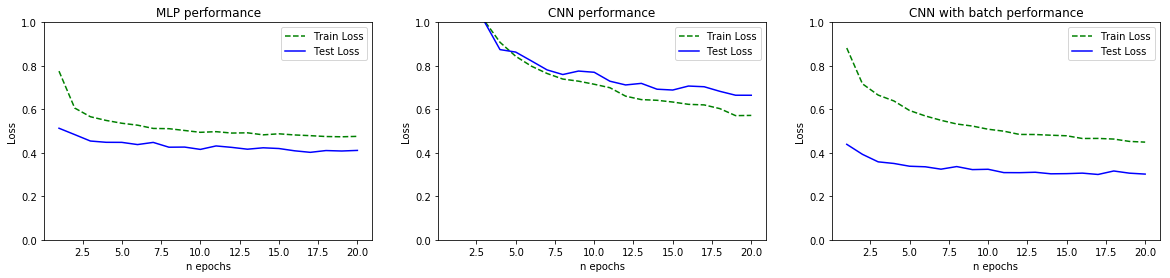

In [17]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 3, 1)
plot_metrics(ax, mlp_metrics, "MLP performance", n_epochs)
ax = fig.add_subplot(1, 3, 2)
plot_metrics(ax, cnn_metrics, "CNN performance", n_epochs)
ax = fig.add_subplot(1, 3, 3)
plot_metrics(ax, cnn_batch_metrics, "CNN with batch performance", n_epochs)

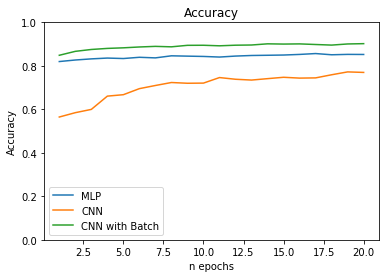

In [18]:
fig = plt.figure()
ax = plt.axes()
plot_accuracy(ax, [mlp_metrics, cnn_metrics, cnn_batch_metrics], ["MLP", "CNN", "CNN with Batch"], n_epochs)

 MLP reached very quickly a plateau that would warrant more complexity/layers to overcome
 
 CNN though is still on an ascending trend (compared to MLP) and more epochs would likely improve the results
 
 CNNs are much longer to trained, it would have been worthed to increase the size of the MLP to reflect this fairly
 
### Batch_norm makes a massive difference

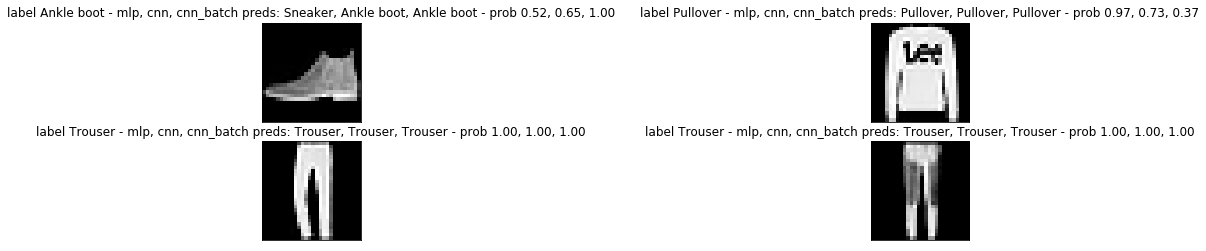

In [23]:
mlp.load_state_dict(torch.load("trained_models\mlp.pt"))
cnn.load_state_dict(torch.load("trained_models\cnn.pt"))
cnn_batch.load_state_dict(torch.load("trained_models\cnn_batch.pt"))

images, labels = next(iter(testloader))
reverse_dict = {b:a for a,b in testset.class_to_idx.items()}

preds_mlp = torch.exp(mlp(images))
top_p_mlp, top_class = preds_mlp.topk(1, dim=1)
preds_mlp = [reverse_dict[int(a.numpy())] for a in top_class]

preds_cnn = torch.exp(cnn(images))
top_p_cnn, top_class = preds_cnn.topk(1, dim=1)
preds_cnn = [reverse_dict[int(a.numpy())] for a in top_class]

preds_cnn_batch = torch.exp(cnn_batch(images))
top_p_cnn_batch, top_class = preds_cnn_batch.topk(1, dim=1)
preds_cnn_batch = [reverse_dict[int(a.numpy())] for a in top_class]

fig = plt.figure(figsize=(20, 4))
plot_size=4
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx][0].numpy()), cmap='gray')
    title = "label {} - mlp, cnn, cnn_batch preds: {}, {}, {} - prob {:.2f}, {:.2f}, {:.2f}".format(
    reverse_dict[int(labels[idx])], preds_mlp[idx], preds_cnn[idx], preds_cnn_batch[idx],
    float(top_p_mlp[idx]), float(top_p_cnn[idx]), float(top_p_cnn_batch[idx])
    )
    plt.title(title) 